In [235]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import math, time, os, datetime, psutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
import random
from memory_profiler import memory_usage
from memory_profiler import memory_usage

In [236]:
col='CallIn'
n_grids=2
seq_len=144

In [237]:
# Loading datad
df_train = pd.read_parquet(f"../data/train_data_2025-06-26_17-16-54.parquet")
df_test = pd.read_parquet(f"../data/test_data_scaled_2025-06-26_17-16-54.parquet")
df_eval = pd.read_parquet(f"../data/eval_data_scaled_2025-06-26_17-16-54.parquet")

In [251]:
df_train['gridID'].unique()

array([ 216, 1009,  927,  794, 2524, 2570, 3236, 2002, 3541, 3778, 1935,
       3882, 1515, 2021])

In [252]:
df_train.shape

(32256, 11)

In [253]:
df_test[df_test['gridID']==7488]

,gridID,SmsIn,SmsOut,CallIn,CallOut,Internet,month,day_of_month,day_of_week,hour,minute
startTime,,,,,,,,,,,
2013-11-01 00:00:00,7488,0.300071,-0.386383,-0.204231,-0.516220,-0.531128,11,1,4,0,0
2013-11-01 00:10:00,7488,0.128874,-0.122698,-0.129153,-0.538234,-0.591438,11,1,4,0,10
2013-11-01 00:20:00,7488,0.185986,-0.238134,-0.185152,-0.527780,-0.567587,11,1,4,0,20
2013-11-01 00:30:00,7488,0.053501,-0.437405,-0.155434,-0.538234,-0.591438,11,1,4,0,30
2013-11-01 00:40:00,7488,-0.243851,-0.416377,-0.192149,-0.581438,-0.385058,11,1,4,0,40
...,...,...,...,...,...,...,...,...,...,...,...
2013-11-16 23:10:00,7488,0.131784,-0.259648,-0.209921,-0.536716,-0.591438,11,16,5,23,10
2013-11-16 23:20:00,7488,0.079652,-0.138448,-0.247007,-0.526674,-0.559738,11,16,5,23,20
2013-11-16 23:30:00,7488,0.122013,-0.280937,-0.132039,-0.406693,-0.434778,11,16,5,23,30


In [248]:
df_test['gridID'].unique()

array([7488, 7839, 7984, 8011, 8454, 8658, 4560, 5216, 5447])

In [244]:
df_eval.shape

(38641, 11)

In [238]:
FEATURES = [col, 'month', 'day_of_month', 'day_of_week', 'hour', 'minute']
TIMESTEPS = 24

<Axes: xlabel='startTime'>

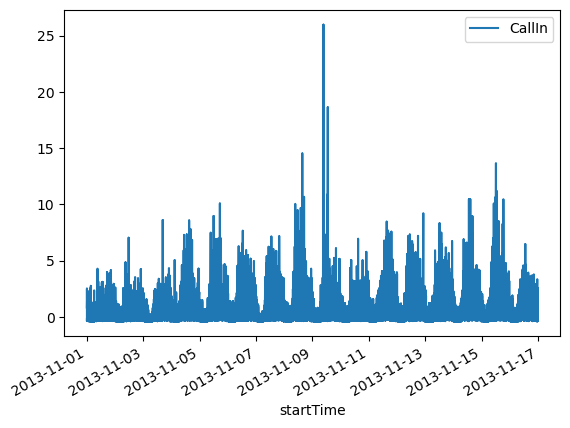

In [239]:
df_test[[col]].plot()

In [245]:
# def run_with_memory(func, *args, **kwargs):
#     mem_before = memory_usage()[0]
#     result = func(*args, **kwargs)
#     mem_after = memory_usage()[0]
#     return result, mem_after - mem_before


# ===========================
# Monitor wrapper function
# ===========================
def run_with_memory_and_time(func, *args, **kwargs):
    start_time = time.time()
    mem_usage, result = memory_usage(
        (func, args, kwargs), retval=True, max_usage=True
    )
    duration = time.time() - start_time
    return result, duration, mem_usage  # returns (function result, time in seconds, peak memory in MB)



def process_grid(grid_id, X_tensor):
    with torch.no_grad():
        recon = models[grid_id](X_tensor)
        mse = ((recon - X_tensor) ** 2).mean(dim=(1, 2)).numpy()
    return mse



# class ResourceMonitor:
#     def __init__(self):
#         self.process = psutil.Process()
#         self.checkpoints = {}

#     def mark(self, label):
#         """Record current time and memory (in MB) under a label"""
#         current_time = time.time()
#         current_mem = self.process.memory_info().rss / (1024 ** 2)  # in MB
#         self.checkpoints[label] = {'time': current_time, 'mem': current_mem}

#     def diff(self, start_label, end_label):
#         """Compute time and memory difference between two marks"""
#         if start_label not in self.checkpoints or end_label not in self.checkpoints:
#             raise ValueError("Both start and end labels must be recorded using mark()")
        
#         start = self.checkpoints[start_label]
#         end = self.checkpoints[end_label]
        
#         time_diff = end['time'] - start['time']
#         mem_diff = end['mem'] - start['mem']
        
#         return round(time_diff, 2), round(mem_diff, 2)



def add_gaussian_noise(series, mean=0, std=2):
    noise = np.random.randn(len(series)) * std + mean
    return series + noise

def split_signal(signal, num_of_splits):
    return np.concatenate(np.array_split(signal, num_of_splits))

def find_valid_splits(array_length):
    return [i for i in range(1, array_length + 1) if array_length % i == 0]


def plot_df(df, col, status=True):
    for grid in df['gridID'].unique():
        df_plt= df[df['gridID']==grid].drop(columns='gridID')
        plt.plot(df_plt.index, df_plt[col], label=f'{col} usage')
        if(status is True):
            colors = df_plt['status'].apply(lambda x: 'red' if x == 'Abnormal' else 'blue')
            plt.scatter(
            df_plt[df_plt['status'] == 'Abnormal'].index,
            df_plt[df_plt['status'] == 'Abnormal'][col],
            c='red',
            label='Abnormal')
        plt.xticks(rotation=45)
        plt.title(f"Grid: {grid}")
        plt.legend()
        plt.tight_layout()
        plt.show()


def add_noise_to_df(df, n_outliers=500, alpha_dev = 0.2, column_index=list(range(1, 6))):
    # Define the noisy region
    pos = int(np.round(len(find_valid_splits(len(df))) / 1.5))
    n_split = find_valid_splits(len(df))[pos]
    
    signal = split_signal(df.iloc[:, 1:6], n_split)  # columns 1–5 (assumes 0-based indexing)
    
    down = random.randint(0, signal.shape[0] - n_outliers)
    up = down + n_outliers
    print(f"Lower boundary {down} - Upper boundary {up}")
    
    # Apply Gaussian noise to each column (1 to 5)

    noisy_cols = []
    
    for col in df.columns[column_index]:
        orig_mean = df[col].mean()
        orig_std = df[col].std()
    
        noise_mean = orig_mean * (1 + alpha_dev)
        noise_std = orig_std * (1 + alpha_dev)
    
        # Apply noise only to selected rows
        signal_col = split_signal(df[col], n_split)
        noisy_part = add_gaussian_noise(signal_col[down:up], mean=noise_mean, std=noise_std)
    
        noisy_part = pd.Series(noisy_part, index=range(down, up))  # optional: specify index
    
        # Combine back into full series
        noisy_signal = pd.concat([
            df[col].iloc[:down],
            noisy_part,
            df[col].iloc[up:]
        ], ignore_index=True)
    
    
        noisy_cols.append(noisy_signal)
    
    # Construct new noisy DataFrame for columns 1–5
    noisy_df_part = pd.concat(noisy_cols, axis=1)
    noisy_df_part.columns = df.columns[column_index]
    
    # Combine with original DataFrame
    df_noisy = df.copy()
    df_noisy.iloc[:, column_index] = noisy_df_part
    
    ## Tracking the noise
    df_noisy['status'] = "Normal"
    df_noisy.iloc[down:up, df_noisy.columns.get_loc('status')] = "Abnormal"
    return(df_noisy)



# def create_sequences(data, timesteps):
#     """Converts scaled data into overlapping sequences for LSTM."""
#     X = []
#     for i in range(len(data) - timesteps):
#         X.append(data[i:(i + timesteps)])
#     return np.array(X)

# class LSTMAutoencoder(nn.Module):
#     """The LSTM Autoencoder model defined using PyTorch."""
#     def __init__(self, n_features, timesteps, embedding_dim, dropout=0.2):
#         super(LSTMAutoencoder, self).__init__()
#         self.timesteps = timesteps
        
#         # Encoder layers
#         self.encoder_lstm1 = nn.LSTM(n_features, 64, batch_first=True)
#         self.encoder_lstm2 = nn.LSTM(64, embedding_dim, batch_first=True)
#         self.dropout = nn.Dropout(dropout)
        
#         # Decoder layers
#         self.decoder_lstm1 = nn.LSTM(embedding_dim, 64, batch_first=True)
#         self.decoder_lstm2 = nn.LSTM(64, 64, batch_first=True)
        
#         # Final output layer
#         self.output_layer = nn.Linear(64, n_features)

#     def forward(self, x):
#         # Encoder
#         x, _ = self.encoder_lstm1(x)
#         x, (hidden, _) = self.encoder_lstm2(x)
#         x = self.dropout(hidden)
        
#         # Repeat the latent vector for each timestep for the decoder
#         latent_vector = x.squeeze(0).unsqueeze(1).repeat(1, self.timesteps, 1)
        
#         # Decoder
#         x, _ = self.decoder_lstm1(latent_vector)
#         x, _ = self.decoder_lstm2(x)
#         x = self.dropout(x)
        
#         # Apply the final linear layer to reconstruct the features
#         return self.output_layer(x)



def create_sequences_with_time(df, col, seq_len=144, return_meta=False):
    df = df.copy()
    df = df.sort_index()

    df['hour'] = df.index.hour / 23.0
    df['minute'] = df.index.minute / 59.0
    df['dayofweek'] = df.index.dayofweek / 6.0

    features = [col, 'hour', 'minute', 'dayofweek']

    sequences_by_grid = {}
    meta_by_grid = {}

    for grid_id, group in df.groupby('gridID'):
        group = group.sort_index()
        data = group[features].values
        index = group.index

        grid_sequences = []
        timestamps = []
        row_indices = []

        for i in range(len(data) - seq_len):
            grid_sequences.append(data[i:i + seq_len])

            if return_meta:
                timestamps.append(index[i + seq_len - 1])
                row_indices.append(group.index.get_loc(index[i + seq_len - 1]))

        sequences_by_grid[grid_id] = np.array(grid_sequences)

        if return_meta:
            meta_by_grid[grid_id] = {
                'timestamps': timestamps,
                'row_indices': row_indices
            }

    if return_meta:
        return sequences_by_grid, timestamps, grid_sequences, row_indices
    else:
        return sequences_by_grid




# ## step 1: Defining autoencoder
# class LSTMAutoencoder(nn.Module):
#     def __init__(self, seq_len, n_features, embedding_dim=64):
#         super(LSTMAutoencoder, self).__init__()
#         self.encoder = nn.LSTM(
#             input_size=n_features,
#             hidden_size=embedding_dim,
#             batch_first=True
#         )
#         self.decoder = nn.LSTM(
#             input_size=embedding_dim,
#             hidden_size=n_features,
#             batch_first=True
#         )
#         self.seq_len = seq_len
#         self.n_features = n_features

#     def forward(self, x):
#         _, (hidden, _) = self.encoder(x)
#         repeated = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2)
#         output, _ = self.decoder(repeated)
#         return output



### Step 2: building the training function

def train_model(model, dataloader, n_epochs=20, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            batch = batch[0].to(device)  # unpack
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.6f}")


# -----------------------------
# Step 1: Define the LSTM Autoencoder
# -----------------------------

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.latent = nn.Linear(hidden_dim, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        # Encoder
        enc_out, _ = self.encoder(x)
        latent = self.latent(enc_out[:, -1, :])
        repeated_latent = latent.unsqueeze(1).repeat(1, x.size(1), 1)

        # Decoder
        dec_in = self.decoder_input(repeated_latent)
        dec_out, _ = self.decoder(dec_in)
        return dec_out

# -----------------------------
# Step 2: Custom Dataset
# -----------------------------

class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

# -----------------------------
# Step 3: Function to Train Per-Grid Model
# -----------------------------

def train_lstm_autoencoder(X_tensor, input_dim, epochs=20, batch_size=64, lr=1e-3):
    dataset = SequenceDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = LSTMAutoencoder(input_dim=input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            output = model(batch)
            loss = loss_fn(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f}")
    return model

# -----------------------------
# Step 4: Create Sequences Per Grid
# -----------------------------

def create_sequences_with_time(df, col, seq_len=144, return_meta=False):
    df = df.copy()
    df = df.sort_index()
    df['hour'] = df.index.hour / 23.0
    df['minute'] = df.index.minute / 59.0
    df['dayofweek'] = df.index.dayofweek / 6.0
    features = [col, 'hour', 'minute', 'dayofweek']

    sequences_by_grid = {}
    meta_by_grid = {}

    for grid_id, group in df.groupby('gridID'):
        group = group.sort_index()
        data = group[features].values
        index = group.index

        grid_sequences = []
        timestamps = []

        for i in range(len(data) - seq_len):
            grid_sequences.append(data[i:i + seq_len])
            if return_meta:
                timestamps.append(index[i + seq_len - 1])

        sequences_by_grid[grid_id] = np.array(grid_sequences)

        if return_meta:
            meta_by_grid[grid_id] = timestamps

    if return_meta:
        return sequences_by_grid, meta_by_grid
    else:
        return sequences_by_grid

# -----------------------------
# Step 5: Train One Model Per Grid
# -----------------------------

def train_models_per_grid(df_train, col, seq_len=144):
    X_by_grid, timestamps_by_grid = create_sequences_with_time(
        df_train, col=col, seq_len=seq_len, return_meta=True
    )

    models = {}
    reconstruction_errors = {}

    for grid_id, X in tqdm(X_by_grid.items(), desc="Training per-grid models"):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        input_dim = X_tensor.shape[2]

        # print(f"\nTraining model for grid {grid_id} ({X_tensor.shape[0]} sequences)...")
        model = train_lstm_autoencoder(X_tensor, input_dim=input_dim)

        # Evaluate reconstruction error
        model.eval()
        with torch.no_grad():
            outputs = model(X_tensor)
            mse = ((outputs - X_tensor) ** 2).mean(dim=(1, 2)).numpy()  # shape: (num_sequences,)
        reconstruction_errors[grid_id] = mse
        models[grid_id] = model

    return models, reconstruction_errors, timestamps_by_grid

In [246]:
## Training

In [221]:
# Run training with monitoring
result, training_time, peak_mem = run_with_memory_and_time(
    train_models_per_grid, df_train, col=col, seq_len=seq_len
)

# Unpack model results
models, errors, timestamps = result

# Save to CSV
timestamp1 = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df_stats = pd.DataFrame([{
    'column': col,
    'timestamp': timestamp1,
    'training_time_sec': round(training_time, 2),
    'peak_memory_MB': round(peak_mem, 2)
}])

output_path = f"../results/training_stats_lstm_{timestamp1}_{col}.csv"
df_stats.to_csv(output_path, index=False)

# Confirm
print(df_stats)
print(f"Saved training stats to: {output_path}")

Training per-grid models:   0%|                          | 0/14 [00:00<?, ?it/s]

Epoch 1/20 | Loss: 5.7394
Epoch 2/20 | Loss: 2.3830
Epoch 3/20 | Loss: 2.0457
Epoch 4/20 | Loss: 1.9233
Epoch 5/20 | Loss: 1.8708
Epoch 6/20 | Loss: 1.8509
Epoch 7/20 | Loss: 1.8629
Epoch 8/20 | Loss: 1.8376
Epoch 9/20 | Loss: 1.8134
Epoch 10/20 | Loss: 1.8168
Epoch 11/20 | Loss: 1.7746
Epoch 12/20 | Loss: 1.7647
Epoch 13/20 | Loss: 1.7643
Epoch 14/20 | Loss: 1.7709
Epoch 15/20 | Loss: 1.7610
Epoch 16/20 | Loss: 1.7672
Epoch 17/20 | Loss: 1.7587
Epoch 18/20 | Loss: 1.7662
Epoch 19/20 | Loss: 1.7528


Training per-grid models:   7%|█▎                | 1/14 [00:08<01:52,  8.63s/it]

Epoch 20/20 | Loss: 1.7532
Epoch 1/20 | Loss: 4.3301
Epoch 2/20 | Loss: 2.2227
Epoch 3/20 | Loss: 1.9898
Epoch 4/20 | Loss: 1.9668
Epoch 5/20 | Loss: 1.9421
Epoch 6/20 | Loss: 1.9189
Epoch 7/20 | Loss: 1.8742
Epoch 8/20 | Loss: 1.8697
Epoch 9/20 | Loss: 1.8638
Epoch 10/20 | Loss: 1.8689
Epoch 11/20 | Loss: 1.8646
Epoch 12/20 | Loss: 1.8692
Epoch 13/20 | Loss: 1.8989
Epoch 14/20 | Loss: 1.8713
Epoch 15/20 | Loss: 1.8069
Epoch 16/20 | Loss: 1.7992
Epoch 17/20 | Loss: 1.8051
Epoch 18/20 | Loss: 1.8136
Epoch 19/20 | Loss: 1.7962


Training per-grid models:  14%|██▌               | 2/14 [00:17<01:47,  8.94s/it]

Epoch 20/20 | Loss: 1.7889
Epoch 1/20 | Loss: 7.4592
Epoch 2/20 | Loss: 2.4426
Epoch 3/20 | Loss: 2.2501
Epoch 4/20 | Loss: 2.0807
Epoch 5/20 | Loss: 1.9731
Epoch 6/20 | Loss: 1.9278
Epoch 7/20 | Loss: 1.8877
Epoch 8/20 | Loss: 1.8655
Epoch 9/20 | Loss: 1.8214
Epoch 10/20 | Loss: 1.8980
Epoch 11/20 | Loss: 2.1292
Epoch 12/20 | Loss: 1.9089
Epoch 13/20 | Loss: 1.8442
Epoch 14/20 | Loss: 1.8359
Epoch 15/20 | Loss: 1.8758
Epoch 16/20 | Loss: 1.8754
Epoch 17/20 | Loss: 1.8573
Epoch 18/20 | Loss: 1.8415
Epoch 19/20 | Loss: 1.8375


Training per-grid models:  21%|███▊              | 3/14 [00:26<01:36,  8.73s/it]

Epoch 20/20 | Loss: 1.8349
Epoch 1/20 | Loss: 4.4067
Epoch 2/20 | Loss: 2.3654
Epoch 3/20 | Loss: 2.0299
Epoch 4/20 | Loss: 1.9059
Epoch 5/20 | Loss: 1.9338
Epoch 6/20 | Loss: 1.9541
Epoch 7/20 | Loss: 1.9061
Epoch 8/20 | Loss: 1.8983
Epoch 9/20 | Loss: 1.8915
Epoch 10/20 | Loss: 1.8828
Epoch 11/20 | Loss: 1.8684
Epoch 12/20 | Loss: 1.8530
Epoch 13/20 | Loss: 1.8700
Epoch 14/20 | Loss: 1.7955
Epoch 15/20 | Loss: 1.7744
Epoch 16/20 | Loss: 1.7392
Epoch 17/20 | Loss: 1.7329
Epoch 18/20 | Loss: 1.7279
Epoch 19/20 | Loss: 1.7274


Training per-grid models:  29%|█████▏            | 4/14 [00:35<01:28,  8.83s/it]

Epoch 20/20 | Loss: 1.7251
Epoch 1/20 | Loss: 5.5450
Epoch 2/20 | Loss: 2.3269
Epoch 3/20 | Loss: 2.0317
Epoch 4/20 | Loss: 1.9218
Epoch 5/20 | Loss: 1.9027
Epoch 6/20 | Loss: 1.8741
Epoch 7/20 | Loss: 1.9759
Epoch 8/20 | Loss: 1.8980
Epoch 9/20 | Loss: 1.8440
Epoch 10/20 | Loss: 1.9008
Epoch 11/20 | Loss: 2.0911
Epoch 12/20 | Loss: 1.9871
Epoch 13/20 | Loss: 1.9641
Epoch 14/20 | Loss: 1.9411
Epoch 15/20 | Loss: 1.9173
Epoch 16/20 | Loss: 1.8971
Epoch 17/20 | Loss: 1.8656
Epoch 18/20 | Loss: 1.8368
Epoch 19/20 | Loss: 1.7981


Training per-grid models:  36%|██████▍           | 5/14 [00:44<01:20,  8.98s/it]

Epoch 20/20 | Loss: 1.7817
Epoch 1/20 | Loss: 3.7239
Epoch 2/20 | Loss: 2.0402
Epoch 3/20 | Loss: 1.9222
Epoch 4/20 | Loss: 1.8778
Epoch 5/20 | Loss: 1.8460
Epoch 6/20 | Loss: 1.8130
Epoch 7/20 | Loss: 1.8006
Epoch 8/20 | Loss: 1.7880
Epoch 9/20 | Loss: 1.7658
Epoch 10/20 | Loss: 1.7555
Epoch 11/20 | Loss: 1.7595
Epoch 12/20 | Loss: 1.7552
Epoch 13/20 | Loss: 1.7502
Epoch 14/20 | Loss: 1.7464
Epoch 15/20 | Loss: 1.7921
Epoch 16/20 | Loss: 2.0552
Epoch 17/20 | Loss: 1.9277
Epoch 18/20 | Loss: 1.9084
Epoch 19/20 | Loss: 1.8916


Training per-grid models:  43%|███████▋          | 6/14 [00:53<01:11,  8.93s/it]

Epoch 20/20 | Loss: 1.9038
Epoch 1/20 | Loss: 3.2612
Epoch 2/20 | Loss: 2.2389
Epoch 3/20 | Loss: 1.8868
Epoch 4/20 | Loss: 1.8487
Epoch 5/20 | Loss: 1.8668
Epoch 6/20 | Loss: 1.8764
Epoch 7/20 | Loss: 1.8753
Epoch 8/20 | Loss: 1.8218
Epoch 9/20 | Loss: 1.7998
Epoch 10/20 | Loss: 1.8241
Epoch 11/20 | Loss: 1.7956
Epoch 12/20 | Loss: 1.8441
Epoch 13/20 | Loss: 1.8172
Epoch 14/20 | Loss: 1.9992
Epoch 15/20 | Loss: 2.1234
Epoch 16/20 | Loss: 2.0002
Epoch 17/20 | Loss: 1.9752
Epoch 18/20 | Loss: 1.9399
Epoch 19/20 | Loss: 1.9040


Training per-grid models:  50%|█████████         | 7/14 [01:02<01:02,  8.95s/it]

Epoch 20/20 | Loss: 1.9015
Epoch 1/20 | Loss: 4.2495
Epoch 2/20 | Loss: 2.3547
Epoch 3/20 | Loss: 2.0327
Epoch 4/20 | Loss: 1.9078
Epoch 5/20 | Loss: 1.9550
Epoch 6/20 | Loss: 1.8908
Epoch 7/20 | Loss: 1.8866
Epoch 8/20 | Loss: 1.9874
Epoch 9/20 | Loss: 2.0146
Epoch 10/20 | Loss: 1.9601
Epoch 11/20 | Loss: 1.9249
Epoch 12/20 | Loss: 1.9070
Epoch 13/20 | Loss: 1.8877
Epoch 14/20 | Loss: 1.8279
Epoch 15/20 | Loss: 1.7570
Epoch 16/20 | Loss: 1.7477
Epoch 17/20 | Loss: 1.7414
Epoch 18/20 | Loss: 1.7373
Epoch 19/20 | Loss: 1.7356


Training per-grid models:  57%|██████████▎       | 8/14 [01:11<00:53,  8.90s/it]

Epoch 20/20 | Loss: 1.7333
Epoch 1/20 | Loss: 5.0439
Epoch 2/20 | Loss: 2.3498
Epoch 3/20 | Loss: 2.0324
Epoch 4/20 | Loss: 1.9607
Epoch 5/20 | Loss: 1.9441
Epoch 6/20 | Loss: 1.9204
Epoch 7/20 | Loss: 1.8216
Epoch 8/20 | Loss: 1.8000
Epoch 9/20 | Loss: 1.7992
Epoch 10/20 | Loss: 1.7926
Epoch 11/20 | Loss: 1.7851
Epoch 12/20 | Loss: 1.7916
Epoch 13/20 | Loss: 1.7853
Epoch 14/20 | Loss: 1.7822
Epoch 15/20 | Loss: 1.7781
Epoch 16/20 | Loss: 1.7735
Epoch 17/20 | Loss: 1.7725
Epoch 18/20 | Loss: 1.7678
Epoch 19/20 | Loss: 1.7716


Training per-grid models:  64%|███████████▌      | 9/14 [01:19<00:43,  8.69s/it]

Epoch 20/20 | Loss: 1.7691
Epoch 1/20 | Loss: 6.6164
Epoch 2/20 | Loss: 4.4146
Epoch 3/20 | Loss: 4.1514
Epoch 4/20 | Loss: 3.9213
Epoch 5/20 | Loss: 2.5245
Epoch 6/20 | Loss: 1.9077
Epoch 7/20 | Loss: 1.8750
Epoch 8/20 | Loss: 1.9093
Epoch 9/20 | Loss: 1.8957
Epoch 10/20 | Loss: 1.8609
Epoch 11/20 | Loss: 1.8430
Epoch 12/20 | Loss: 1.8435
Epoch 13/20 | Loss: 1.8441
Epoch 14/20 | Loss: 1.8422
Epoch 15/20 | Loss: 1.8424
Epoch 16/20 | Loss: 1.8436
Epoch 17/20 | Loss: 1.8404
Epoch 18/20 | Loss: 1.8432
Epoch 19/20 | Loss: 1.8398


Training per-grid models:  71%|████████████▏    | 10/14 [01:27<00:33,  8.48s/it]

Epoch 20/20 | Loss: 1.8414
Epoch 1/20 | Loss: 9.2695
Epoch 2/20 | Loss: 5.2467
Epoch 3/20 | Loss: 5.1218
Epoch 4/20 | Loss: 4.9948
Epoch 5/20 | Loss: 4.7720
Epoch 6/20 | Loss: 4.8181
Epoch 7/20 | Loss: 4.7788
Epoch 8/20 | Loss: 5.2062
Epoch 9/20 | Loss: 5.0387
Epoch 10/20 | Loss: 4.7392
Epoch 11/20 | Loss: 4.9655
Epoch 12/20 | Loss: 4.7990
Epoch 13/20 | Loss: 4.9397
Epoch 14/20 | Loss: 4.7851
Epoch 15/20 | Loss: 4.7989
Epoch 16/20 | Loss: 4.6977
Epoch 17/20 | Loss: 4.6262
Epoch 18/20 | Loss: 4.6153
Epoch 19/20 | Loss: 4.7679


Training per-grid models:  79%|█████████████▎   | 11/14 [01:35<00:25,  8.35s/it]

Epoch 20/20 | Loss: 4.6470
Epoch 1/20 | Loss: 4.5525
Epoch 2/20 | Loss: 2.3323
Epoch 3/20 | Loss: 1.9888
Epoch 4/20 | Loss: 1.9231
Epoch 5/20 | Loss: 1.9113
Epoch 6/20 | Loss: 1.9022
Epoch 7/20 | Loss: 1.8711
Epoch 8/20 | Loss: 1.9110
Epoch 9/20 | Loss: 1.8126
Epoch 10/20 | Loss: 1.8250
Epoch 11/20 | Loss: 1.7801
Epoch 12/20 | Loss: 1.7652
Epoch 13/20 | Loss: 1.7600
Epoch 14/20 | Loss: 1.7633
Epoch 15/20 | Loss: 1.7537
Epoch 16/20 | Loss: 1.7520
Epoch 17/20 | Loss: 1.7459
Epoch 18/20 | Loss: 1.7470
Epoch 19/20 | Loss: 1.7430


Training per-grid models:  86%|██████████████▌  | 12/14 [01:43<00:16,  8.28s/it]

Epoch 20/20 | Loss: 1.7379
Epoch 1/20 | Loss: 5.7519
Epoch 2/20 | Loss: 3.2720
Epoch 3/20 | Loss: 3.0533
Epoch 4/20 | Loss: 2.8165
Epoch 5/20 | Loss: 2.7877
Epoch 6/20 | Loss: 2.7422
Epoch 7/20 | Loss: 2.6914
Epoch 8/20 | Loss: 2.7123
Epoch 9/20 | Loss: 2.7654
Epoch 10/20 | Loss: 2.7413
Epoch 11/20 | Loss: 2.7389
Epoch 12/20 | Loss: 2.7365
Epoch 13/20 | Loss: 2.7342
Epoch 14/20 | Loss: 2.8735
Epoch 15/20 | Loss: 2.8183
Epoch 16/20 | Loss: 2.6867
Epoch 17/20 | Loss: 2.6930
Epoch 18/20 | Loss: 2.6812
Epoch 19/20 | Loss: 2.6747


Training per-grid models:  93%|███████████████▊ | 13/14 [01:51<00:08,  8.21s/it]

Epoch 20/20 | Loss: 2.6695
Epoch 1/20 | Loss: 3.8709
Epoch 2/20 | Loss: 2.4364
Epoch 3/20 | Loss: 2.2507
Epoch 4/20 | Loss: 2.2193
Epoch 5/20 | Loss: 2.1935
Epoch 6/20 | Loss: 2.1337
Epoch 7/20 | Loss: 2.1156
Epoch 8/20 | Loss: 2.1003
Epoch 9/20 | Loss: 2.0997
Epoch 10/20 | Loss: 2.0939
Epoch 11/20 | Loss: 2.0891
Epoch 12/20 | Loss: 2.0893
Epoch 13/20 | Loss: 2.0846
Epoch 14/20 | Loss: 2.0806
Epoch 15/20 | Loss: 2.0965
Epoch 16/20 | Loss: 2.0832
Epoch 17/20 | Loss: 2.0766
Epoch 18/20 | Loss: 2.0774
Epoch 19/20 | Loss: 2.0700


Training per-grid models: 100%|█████████████████| 14/14 [01:59<00:00,  8.55s/it]

Epoch 20/20 | Loss: 2.0696
   column            timestamp  training_time_sec  peak_memory_MB
0  CallIn  2025-06-27_09-04-53             120.61         2405.43
Saved training stats to: ../results/training_stats_lstm_2025-06-27_09-04-53_CallIn.csv


In [222]:
### Extracting anomalies
thresholds = {}
anomalies = {}

for grid_id, mse_array in errors.items():
    threshold = np.percentile(mse_array, 95)
    abnormal = mse_array > threshold
    thresholds[grid_id] = threshold
    anomalies[grid_id] = abnormal

In [223]:
thresholds

{216: 0.10144011005759226,
 794: 0.10372473821043965,
 927: 0.11976349651813487,
 1009: 0.09864757806062689,
 1515: 0.10129856243729589,
 1935: 0.12545820102095592,
 2002: 0.10081031918525682,
 2021: 0.09892607890069482,
 2524: 0.09957886897027486,
 2570: 0.11974435672163941,
 3236: 0.18006745278835293,
 3541: 0.10078889504075043,
 3778: 0.11821821369230748,
 3882: 0.1078390587121248}

In [224]:
df_test = df_eval[df_eval['gridID'].isin(df_train['gridID'].unique())]

In [225]:
## Adding noise to training data to verify model performance
df_noisy = add_noise_to_df(df=df_test, n_outliers=1000, alpha_dev=0.2, column_index=list(range(1, 6)))

df_noisy

Lower boundary 8033 - Upper boundary 9033


/home/mfondoum/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/mfondoum/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


,gridID,SmsIn,SmsOut,CallIn,CallOut,Internet,month,day_of_month,day_of_week,hour,minute,status
startTime,,,,,,,,,,,,
2013-12-18 00:00:00,216,-0.430013,-0.503932,-0.500486,-0.452446,-0.433752,12,18,2,0,0,Normal
2013-12-18 00:00:00,794,-0.592913,-0.445224,-0.258781,-0.527422,-0.607618,12,18,2,0,0,Normal
2013-12-18 00:00:00,927,-0.143994,-0.536830,-0.421686,-0.592625,-0.611652,12,18,2,0,0,Normal
2013-12-18 00:00:00,1009,-0.475666,-0.620875,-0.563108,-0.474615,-0.658156,12,18,2,0,0,Normal
2013-12-18 00:00:00,1515,-0.461918,-0.648428,-0.498306,-0.658191,-0.643034,12,18,2,0,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-01 23:50:00,794,-0.569462,-0.222876,0.110764,-0.600126,-0.595818,1,1,2,23,50,Normal
2014-01-01 23:50:00,3541,-0.122050,-0.435530,-0.141898,-0.382877,-0.626158,1,1,2,23,50,Normal
2014-01-01 23:50:00,3778,3.103546,0.315203,1.512240,0.181584,-0.458663,1,1,2,23,50,Normal


In [226]:
X_test, timestamps_test = create_sequences_with_time(
    df_noisy, col=col, seq_len=144, return_meta=True
)

In [234]:
start_time=time.time() ### Measuring start time

anomaly_results = {}
resource_logs = []

for grid_id, X_seq in X_test.items():
    if grid_id not in models:
        print(f"Skipping grid {grid_id}: no trained model available.")
        continue

    model = models[grid_id]
    model.eval()
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    def process_grid():
        with torch.no_grad():
            recon = model(X_tensor)
            mse = ((recon - X_tensor) ** 2).mean(dim=(1, 2)).numpy()
        return mse

    mse, test_time, peak_mem  = run_with_memory_and_time(process_grid)

    threshold = np.percentile(errors[grid_id], 95)
    abnormal = mse > threshold

    anomaly_results[grid_id] = {
        'mse': mse,
        'threshold': threshold,
        'anomalies': abnormal,
        'timestamps': timestamps_test[grid_id]
    }

    print(f"{grid_id}: {abnormal.sum()} anomalies | Peak Mem: {peak_mem:.2f} MB")

    resource_logs.append({
        'gridID': grid_id,
        'anomalies': int(abnormal.sum()),
        'peak_memory_MB': peak_mem
    })

test_time = time.time() - start_time
### End of code update
print(f"Test time: {test_time:.2f}s")

216: 266 anomalies | Peak Mem: 1926.23 MB
794: 1221 anomalies | Peak Mem: 1944.48 MB
927: 250 anomalies | Peak Mem: 1940.70 MB
1009: 277 anomalies | Peak Mem: 1942.63 MB
1515: 280 anomalies | Peak Mem: 1940.44 MB
2021: 582 anomalies | Peak Mem: 1944.73 MB
2524: 1183 anomalies | Peak Mem: 1942.80 MB
2570: 434 anomalies | Peak Mem: 1941.04 MB
3541: 642 anomalies | Peak Mem: 1943.47 MB
3778: 2016 anomalies | Peak Mem: 1945.12 MB
3882: 2016 anomalies | Peak Mem: 1946.72 MB
Test time: 6.09s


In [232]:
# Unpack model results
# models, errors, timestamps = result

# Save to CSV
timestamp1 = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df_stats = pd.DataFrame([{
    'column': col,
    'timestamp': timestamp1,
    'training_time_sec': round(training_time, 2),
    'peak_memory_MB': round(peak_mem, 2)
}])

output_path = f"../results/test_stats_lstm_{timestamp1}_{col}.csv"
df_stats.to_csv(output_path, index=False)

# Confirm
print(df_stats)
print(f"Saved Test stats to: {output_path}")

   column            timestamp  training_time_sec  peak_memory_MB
0  CallIn  2025-06-27_09-20-41             120.61         2259.17
Saved Test stats to: ../results/test_stats_lstm_2025-06-27_09-20-41_CallIn.csv


In [233]:
# print(f"\n=== TOTAL TESTING ===")
# print(f"Total time: {total_time:.2f}s | Total memory: {total_mem:.2f} MB")

# timestamp1 = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# df_resource = pd.DataFrame(resource_logs)
# df_resource.to_csv(f"../results/resource_usage_testing_{col}_per_grid_{timestamp1}.csv", index=False)

In [194]:
records = []

for grid_id, result in anomaly_results.items():
    mse_values = result['mse']
    anomaly_flags = result['anomalies']
    timestamps = result['timestamps']
    threshold = result['threshold']

    for mse, is_anomaly, ts in zip(mse_values, anomaly_flags, timestamps):
        records.append({
            'gridID': grid_id,
            'timestamp': ts,
            'mse': mse,
            'threshold': threshold,
            'status': 'Abnormal' if is_anomaly else 'Normal'
        })

df_anomaly_results = pd.DataFrame(records)

In [195]:
df_anomaly_results.sort_values(['gridID', 'timestamp'], inplace=True)

In [196]:
df_plt['threshold'].unique()

array([0.11092876])

In [218]:
# plot_df(df_anomaly_results, col='mse')

In [198]:
df_merged = df_noisy.reset_index()  # if timestamp is index
df_merged = df_merged[['gridID', 'startTime', col, 'status']].rename(columns={'startTime': 'timestamp','status':'actual_status'})
df_merged = df_anomaly_results.merge(df_merged, on=['gridID', 'timestamp'], how='left')
df_merged

,gridID,timestamp,mse,threshold,status,CallIn,actual_status
0,216,2013-12-18 23:50:00,0.047381,0.103796,Normal,-0.124533,Normal
1,216,2013-12-19 00:00:00,0.048311,0.103796,Normal,-0.544652,Normal
2,216,2013-12-19 00:10:00,0.048903,0.103796,Normal,-0.522569,Normal
3,216,2013-12-19 00:20:00,0.048964,0.103796,Normal,-0.506718,Normal
4,216,2013-12-19 00:30:00,0.048939,0.103796,Normal,-0.436977,Normal
...,...,...,...,...,...,...,...
22171,3882,2014-01-01 23:00:00,1.181782,0.105213,Abnormal,-0.069796,Normal
22172,3882,2014-01-01 23:10:00,1.135612,0.105213,Abnormal,-0.142368,Normal
22173,3882,2014-01-01 23:20:00,1.133487,0.105213,Abnormal,-0.273601,Normal
22174,3882,2014-01-01 23:30:00,1.131933,0.105213,Abnormal,-0.242904,Normal


In [184]:
confusion_matrix(df_merged['actual_status'], df_merged['status'])

array([[  799,   201],
       [ 8569, 12607]])

In [207]:
error_test_df=df_merged

In [213]:
error_test_df = error_test_df.rename(columns={'mse': 'residual'})
error_test_df

,gridID,timestamp,residual,threshold,status,CallIn,actual_status
0,216,2013-12-18 23:50:00,0.047381,0.103796,Normal,-0.124533,Normal
1,216,2013-12-19 00:00:00,0.048311,0.103796,Normal,-0.544652,Normal
2,216,2013-12-19 00:10:00,0.048903,0.103796,Normal,-0.522569,Normal
3,216,2013-12-19 00:20:00,0.048964,0.103796,Normal,-0.506718,Normal
4,216,2013-12-19 00:30:00,0.048939,0.103796,Normal,-0.436977,Normal
...,...,...,...,...,...,...,...
22171,3882,2014-01-01 23:00:00,1.181782,0.105213,Abnormal,-0.069796,Normal
22172,3882,2014-01-01 23:10:00,1.135612,0.105213,Abnormal,-0.142368,Normal
22173,3882,2014-01-01 23:20:00,1.133487,0.105213,Abnormal,-0.273601,Normal
22174,3882,2014-01-01 23:30:00,1.131933,0.105213,Abnormal,-0.242904,Normal


In [214]:
metrics = []

for grid, group in error_test_df.groupby('gridID'):
    y_true = group['actual_status'].map({'Normal': 0, 'Abnormal': 1}).astype(int)
    y_pred = group['status'].map({'Normal': 0, 'Abnormal': 1}).astype(int)

    # Compute confusion matrix
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    except ValueError:
        tn = fp = fn = tp = float('nan')

    # Compute AUROC, if possible
    try:
        auroc = roc_auc_score(y_true, group['residual'].abs())
    except ValueError:
        auroc = float('nan')

    metrics.append({
        'gridID': grid,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'auroc': auroc,
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn
    })

In [215]:
timestamp1 = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
metrics_df = pd.DataFrame(metrics)
metrics_df

,gridID,accuracy,precision,recall,f1_score,auroc,true_positive,true_negative,false_positive,false_negative
0,216,0.865079,0.196667,0.655556,0.302564,0.867471,59,1685,241,31
1,794,0.375496,0.053517,0.769231,0.100071,0.565977,70,687,1238,21
2,927,0.873512,0.230263,0.769231,0.354430,0.878099,70,1691,234,21
3,1009,0.887897,0.238281,0.663043,0.350575,0.847962,61,1729,195,31
4,1515,0.873016,0.225914,0.747253,0.346939,0.895447,68,1692,233,23
5,2021,0.812500,0.157518,0.725275,0.258824,0.846999,66,1572,353,25
6,2524,0.433532,0.062448,0.824176,0.116099,0.728905,75,799,1126,16
7,2570,0.740575,0.125000,0.791209,0.215892,0.875427,72,1421,504,19
8,3541,0.698413,0.114754,0.846154,0.202100,0.870752,77,1331,594,14
9,3778,0.044643,0.044643,1.000000,0.085470,0.129185,90,0,1926,0


In [216]:
metrics_df.to_csv(f"../results/lstm_model_metrics_{col}_{timestamp1}.csv")